In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import pysentiment2 as ps
from tqdm import tqdm
tqdm.pandas()

In [2]:
df = pd.read_csv("../data/processed/clean_df.csv")
df

,date,exchange,q,ticker,transcript,year,time,before,after,change_during_news,change_day_after,change_week_after,change_month_after,processed_transcript
0,2020-08-27 21:00:00,NASDAQ,Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel...",2020,21:00:00,False,True,0.012627,0.036753,0.027565,-0.088602,"['prepared', 'remarks', 'operator', 'good', 'd..."
1,2020-07-30 16:30:00,NYSE,Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...,2020,16:30:00,False,True,0.048934,0.056351,0.069746,0.065570,"['prepared', 'remarks', 'operator', 'thank', '..."
2,2019-10-23 17:00:00,NASDAQ,Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...,2019,17:00:00,False,True,0.082640,0.052090,0.096415,0.051614,"['prepared', 'remarks', 'operator', 'good', 'd..."
3,2019-08-07 08:30:00,NASDAQ,Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...,2019,08:30:00,True,False,-0.069474,0.164404,0.188537,0.141780,"['prepared', 'remarks', 'operator', 'greetings..."
4,2020-11-04 17:00:00,NYSE,Q3,GDOT,"Prepared Remarks:\nOperator\nGood afternoon, a...",2020,17:00:00,False,True,0.030364,-0.045350,-0.023469,-0.049409,"['prepared', 'remarks', 'operator', 'good', 'a..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11200,2021-08-11 08:00:00,NYSE,Q1,HAE,Prepared Remarks:\nOperator\nGood day and than...,2021,08:00:00,True,False,0.013331,0.058773,0.016402,0.076542,"['prepared', 'remarks', 'operator', 'good', 'd..."
11201,2021-08-12 16:30:00,NASDAQ,Q3,AVXL,Prepared Remarks:\nOperator\nGood afternoon. M...,2021,16:30:00,False,True,-0.007784,0.022489,-0.047071,-0.006276,"['prepared', 'remarks', 'operator', 'good', 'a..."
11202,2022-08-24 17:00:00,NASDAQ,Q2,NVDA,Prepared Remarks:\nOperator\nGood afternoon. M...,2022,17:00:00,False,True,-0.021949,0.063465,-0.156436,-0.262645,"['prepared', 'remarks', 'operator', 'good', 'a..."
11203,2022-08-04 17:00:00,NASDAQ,Q2,DH,"Prepared Remarks:\nOperator\nGood day, and wel...",2022,17:00:00,False,True,-0.216843,0.066826,0.009578,-0.150196,"['prepared', 'remarks', 'operator', 'good', 'd..."


In [3]:
text = df.iloc[0].transcript

In [4]:
# BOW using Loughran and McDonald dictionary
lm = ps.LM()
tokens = lm.tokenize(text)
score = lm.get_score(tokens)
score

{'Positive': 125,
 'Negative': 99,
 'Polarity': 0.11607142805325256,
 'Subjectivity': 0.08414725766936618}

In [5]:
# BOW using Loughran and McDonald dictionary
lm = ps.LM()

def calculate_scores(transcript):
    tokens = lm.tokenize(transcript)
    score = lm.get_score(tokens)
    return pd.Series(score['Polarity'])

# # Only take the first 5% of the data
# test = df.head(int(len(df) * 0.05))

BOW_pol = df['transcript'].progress_apply(calculate_scores)
BOW_pol.columns = ['Polarity']

df.to_csv("../data/processed/BOW_pol.csv", index=False)

100%|██████████| 11205/11205 [07:37<00:00, 24.51it/s]


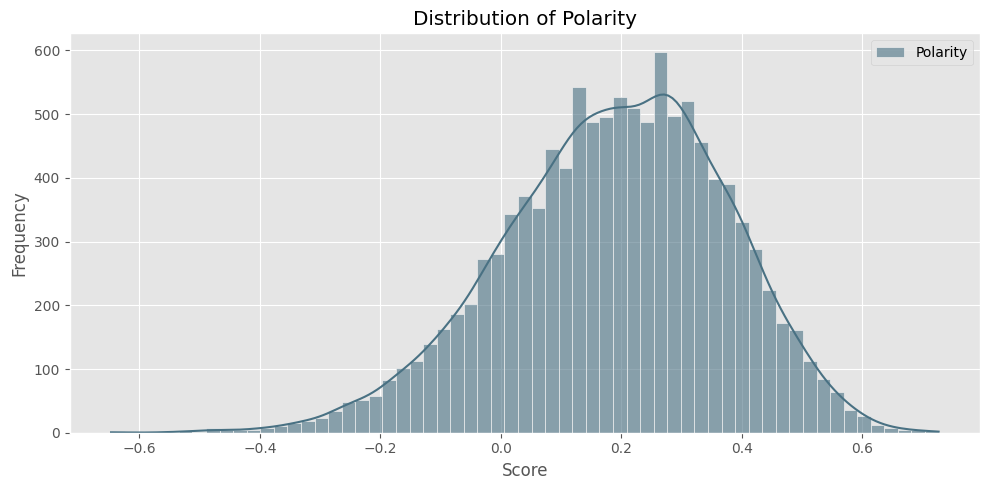

In [9]:
# Plot the distribution of polarity and subjectivity
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(BOW_pol['Polarity'], ax=ax, label='Polarity', kde=True, color='#497183', alpha=0.6)
ax.set_title('Distribution of Polarity')
ax.set_xlabel('Score')
ax.set_ylabel('Frequency')
ax.legend()
plt.tight_layout()
plt.show()


In [8]:
BOW_pol.to_csv("../data/processed/BOW_pol.csv", index=False)

In [10]:
def compute_class(threshold_neg, threshold_pos, score):
    if score < threshold_neg:
        return 'Negative'
    elif score > threshold_pos:
        return 'Positive'
    else:
        return 'Neutral'

In [14]:
BOW_pol['Class'] = BOW_pol['Polarity'].apply(lambda x: compute_class(-0.2, 0.2, x))

In [15]:
BOW_pol.Class.value_counts()

Class
Positive    7783
Neutral     3138
Negative     284
Name: count, dtype: int64